Общие замечания по данным:
1) данные имеют линейно зависимые фичи (площади разбиты по составляющим, например: есть жилая зона и несколько зон, которые в сумме образуют жилую зону) --- их обязательно определять и удалять, так как ухудшается обусловленность матрицы
2) довольно полезным оказалось логарифмирование таргета, предполагаемая причина --- чисто по значениям разброс слишком высок, и случайное отклонение в значениях цены портило модель.
3) сделать упор на дома средней цены оказалось наиболее эффективным: судя по всему цена у дешевых домов растет медленно, у дорогих слишком быстро, и получается, что зависимость линейная для домов средней ценовой категории.

In [53]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from typing import Optional, List

class BaseDataPreprocessor(TransformerMixin):
    def __init__(self, needed_columns: Optional[List[str]]=None, **kwargs):
        """
        :param needed_columns: if not None select these columns from the dataframe
        """

        if needed_columns != None:
            self.needed_cols = needed_columns
        else:
            self.needed_cols = -1
        self.scaler = StandardScaler()

    def fit(self, data, *args):
        self.scaler.fit(data[self.needed_cols if self.needed_cols != -1 else data.columns])
        return self
    def get_params(self, **kwargs):
        return {'needed_columns': self.needed_cols}
    def transform(self, data: pd.DataFrame) -> np.array:
        return self.scaler.transform(data[self.needed_cols if self.needed_cols != -1 else data.columns])


In [2]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

class ExponentialLinearRegression(RegressorMixin):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.r = Ridge(*args, **kwargs)
    def fit(self, X, Y):
        loged_y = np.log(np.array(Y))
        self.r.fit(X, loged_y)
        return self
    def predict(self, X):
        loged_res = self.r.predict(X)
        return np.exp(loged_res)

    def get_params(self, deep=True):
        return self.r.get_params(deep=deep)
    
    def set_params(self, *args, **kwargs):
        self.r.set_params(**kwargs)
        return self


In [19]:
def make_ultimate_pipeline(continuous_columns):
    interesting_columns = ["Overall Qual", "Garage Qual", "Sale Condition", "MS Zoning"]
    trash = ['PID', 'Order', 'Total Bsmt SF', 'Gr Liv Area', 'TotRms AbvGrd', 'SalePrice']
    
    continuous_columns = list(set(continuous_columns).difference(set(trash)))

    column_tr = ColumnTransformer(
        transformers=[
        ('OneHotPreprocessor', OneHotEncoder(handle_unknown='ignore'), interesting_columns),
        ('BasePreprocessor', BaseDataPreprocessor(), continuous_columns),
    ]
    )
    imp = SimpleImputer()
    return Pipeline([
        ('columns_transform', column_tr),
        ('Imputer', imp),
        ('Ridge', ExponentialLinearRegression())
    ])

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
data = pd.read_csv('data.csv')
thrown = pd.concat([data[data['SalePrice'] > 300000], data[data['SalePrice'] < 50000]])
data = data[data['SalePrice'] < 300000]
data = data[data['SalePrice'] > 50000]
trash = ['PID', 'Order', 'Total Bsmt SF', 'Gr Liv Area', 'TotRms AbvGrd', 'SalePrice']
continuous_columns = [key for key in data.keys() if data[key].dtype in ("int64", "float64")]
continuous_columns = list(set(continuous_columns).difference(set(trash)))

xtr, xt, ytr, yt = train_test_split(data, data['SalePrice'])


In [40]:
t = make_ultimate_pipeline(continuous_columns)
t.fit(xtr, ytr)

Pipeline(steps=[('columns_transform',
                 ColumnTransformer(transformers=[('OneHotPreprocessor',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Overall Qual',
                                                   'Garage Qual',
                                                   'Sale Condition',
                                                   'MS Zoning']),
                                                 ('BasePreprocessor',
                                                  <__main__.BaseDataPreprocessor object at 0x000002033F32C6D0>,
                                                  ['Open Porch SF',
                                                   'Low Qual Fin SF',
                                                   'Enclosed Porch',
                                                   'Bsmt Full Bath',
                                                   'Kitchen AbvGr', 'Pool Area...
                                                   '3Ssn Porch', 'Half Bath',
                                                   'Screen Porch', 'Yr Sold',
                                                   'Mas Vnr Area', 'Year Built',
                                                   'Overall Qual',
                                                   'Year Remod/Add',
                                                   'BsmtFin SF 1',
                                                   'Lot Frontage',
                                                   'Garage Cars',
                                                   'Bedroom AbvGr',
                                                   'Garage Yr Blt',
                                                   'Wood Deck SF',
                                                   'Overall Cond', '2nd Flr SF',
                                                   'Lot Area', 'Fireplaces',
                                                   'Bsmt Unf SF', 'Mo Sold', ...])])),
                ('Imputer', SimpleImputer()),
                ('Ridge',
                 <__main__.ExponentialLinearRegression object at 0x000002033EFB9B90>)])

In [52]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
print('MAE:', mean_absolute_error(yt, t.predict(xt)))
print('MAPE:', mean_absolute_percentage_error(yt, t.predict(xt)))

MAE: 12980.743131573781
MAPE: 0.0817863312702655


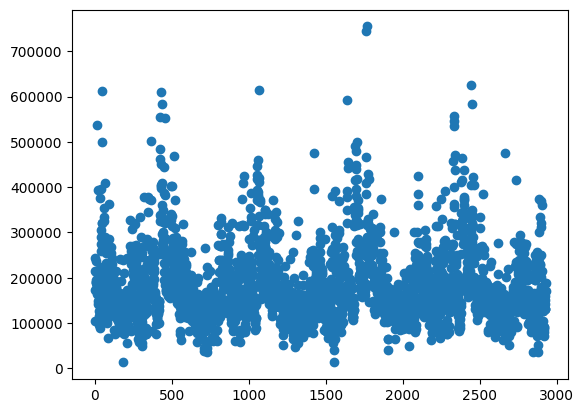

In [37]:
import matplotlib.pyplot as plt
plt.scatter(range(data.shape[0]), YYY)

In [38]:
YYY.mean()

180796.0600682594